Max Contribution Ratio: 0.1 | Temps moyen perdu: 39.78 | Accuracy moyenne: 64.54%
Max Contribution Ratio: 0.2 | Temps moyen perdu: 9.38 | Accuracy moyenne: 69.54%
Max Contribution Ratio: 0.3 | Temps moyen perdu: 5.44 | Accuracy moyenne: 70.17%
Max Contribution Ratio: 0.4 | Temps moyen perdu: 4.08 | Accuracy moyenne: 68.97%
Max Contribution Ratio: 0.5 | Temps moyen perdu: 4.44 | Accuracy moyenne: 69.24%
Max Contribution Ratio: 0.6 | Temps moyen perdu: 2.90 | Accuracy moyenne: 69.92%
Max Contribution Ratio: 0.7 | Temps moyen perdu: 2.08 | Accuracy moyenne: 70.06%
Max Contribution Ratio: 0.8 | Temps moyen perdu: 3.40 | Accuracy moyenne: 69.79%
Max Contribution Ratio: 0.9 | Temps moyen perdu: 3.22 | Accuracy moyenne: 70.24%
Max Contribution Ratio: 1.0 | Temps moyen perdu: 3.14 | Accuracy moyenne: 69.58%


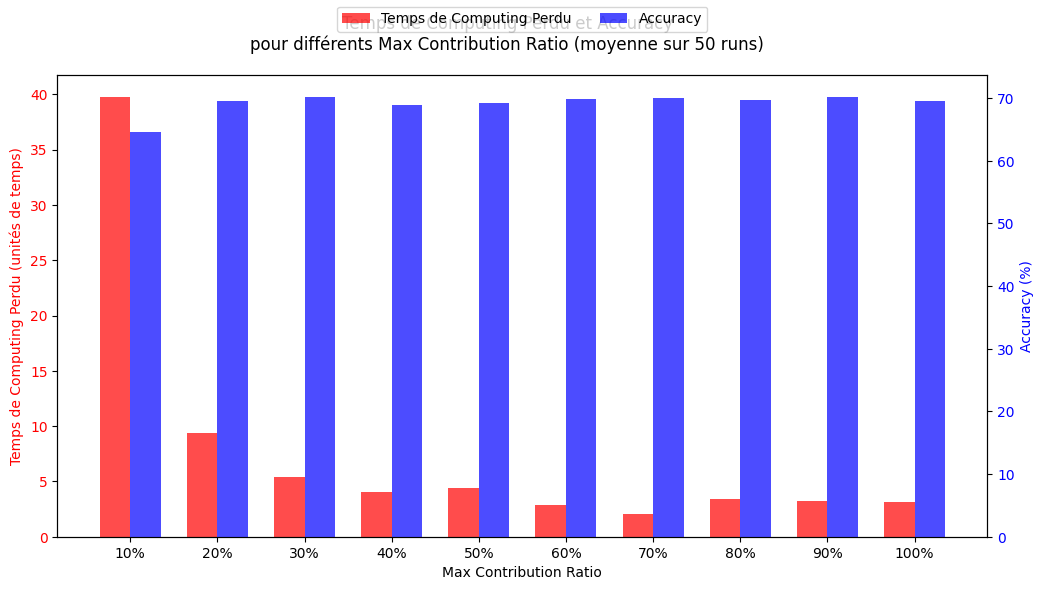

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_dynamic_availability(total_time_steps, worker_id, num_workers, max_periods=5, min_processing_time=2):
    # On définit le centre de la simulation
    center = total_time_steps / 2
    # On fixe un offset maximum (par exemple total_time_steps / 8)
    max_offset = total_time_steps / 8
    # Calcul de l'offset pour chaque worker de façon symétrique
    if num_workers % 2 == 1:
        mid = (num_workers + 1) / 2
        offset = ((worker_id - mid) / mid) * max_offset
    else:
        mid = num_workers / 2
        offset = ((worker_id - mid - 0.5) / mid) * max_offset
    base_mean = center + offset
    # On ajoute un petit aléa pour éviter une régularité trop marquée
    mean = int(np.clip(base_mean + random.randint(-total_time_steps // 20, total_time_steps // 20), 0, total_time_steps - min_processing_time))
    std_dev = total_time_steps / 6
    availability_periods = []
    num_periods = random.randint(1, max_periods)
    for _ in range(num_periods):
        start_time = int(np.clip(np.random.normal(mean, std_dev), 0, total_time_steps - min_processing_time))
        duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
        end_time = min(start_time + duration, total_time_steps)
        if end_time - start_time >= min_processing_time:
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch complet avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Worker adapté pour traiter un mini-batch identifié par (complete_batch_id, mini_batch_id)
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None  # (complete_batch_id, mini_batch_id)
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info is None or self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Serveur qui gère le batch complet, le découpage en mini-batches, l'agrégation des gradients,
# et la logique de contribution maximale par worker.
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.001, verbose=False, max_contribution_ratio=1.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_complete_batch = None   # (data, targets)
        self.current_batch_id = 0
        self.current_mini_batches = {}       # {mini_batch_id: (data, targets)}
        self.received_gradients = {}         # {mini_batch_id: gradient}
        self.total_wasted_time = 0           # Temps de computing perdu (pour doublons et contributions refusées)
        self.verbose = verbose
        self.sent_once = {}                  # Suivi de l'envoi de chaque mini-batch
        self.max_contribution_ratio = max_contribution_ratio  # Ratio max autorisé par worker (< 1 pour limiter)
        self.worker_contributions = {}       # Nombre de contributions acceptées par worker

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_complete_batch = (data, targets)
        self.current_batch_id += 1

        num_samples = data.size(0)
        mini_batches = []
        for i in range(0, num_samples, self.mini_batch_size):
            mini_data = data[i: i + self.mini_batch_size]
            mini_targets = targets[i: i + self.mini_batch_size]
            mini_batches.append((mini_data, mini_targets))
        self.current_mini_batches = {i: mini_batches[i] for i in range(len(mini_batches))}
        self.received_gradients = {}
        self.sent_once = {i: False for i in range(len(mini_batches))}
        if self.verbose:
            print(f"[Temps {current_time}] Batch complet {self.current_batch_id} divisé en {len(mini_batches)} mini-batches.")

    def update_with_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time):
        batch_id, mini_idx = batch_info
        if batch_id != self.current_batch_id:
            return
        # Vérifier le max contribution ratio
        if self.max_contribution_ratio < 1.0:
            total_contrib = sum(self.worker_contributions.values()) if self.worker_contributions else 0
            if total_contrib > 0:
                worker_ratio = self.worker_contributions.get(worker_id, 0) / total_contrib
                if worker_ratio >= self.max_contribution_ratio:
                    # Refuser la contribution et comptabiliser le temps perdu
                    self.total_wasted_time += worker_processing_time
                    if self.verbose:
                        print(f"[Temps {current_time}] Contribution refusée pour mini-batch {mini_idx} par worker {worker_id} (ratio: {worker_ratio:.2f}). Temps perdu: {worker_processing_time}")
                    return
        if mini_idx in self.received_gradients:
            self.total_wasted_time += worker_processing_time
            if self.verbose:
                print(f"[Temps {current_time}] Doublon pour mini-batch {mini_idx} par worker {worker_id} (wasted: {worker_processing_time}).")
            return
        self.received_gradients[mini_idx] = gradients
        # Mettre à jour le compteur de contributions pour ce worker
        self.worker_contributions[worker_id] = self.worker_contributions.get(worker_id, 0) + 1
        if self.verbose:
            print(f"[Temps {current_time}] Gradient accepté pour mini-batch {mini_idx} (batch {batch_id}) par worker {worker_id}.")

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("Attention : tous les mini-batches n'ont pas été traités.")
            return False
        aggregated_gradients = {}
        num_batches = len(self.current_mini_batches)
        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[idx][name] for idx in self.received_gradients]
            aggregated_gradients[name] = sum(grads) / num_batches
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggregated_gradients[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour avec le batch complet {self.current_batch_id}.")
        return True

    def compute_wasted_computing_time(self):
        return self.total_wasted_time

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré adaptée pour traiter le batch comme un buffer unique
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.in_progress_workers = []

    def run(self, verbose=False):
        if verbose:
            print("Démarrage de la simulation...")
        self.server.get_new_complete_batch(self.global_time)

        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"\n[Temps {self.global_time}]")
            finished_workers = []
            for worker in self.in_progress_workers:
                if worker.has_finished(self.global_time):
                    mini_idx = worker.current_batch_info[1]
                    gradients, batch_info = worker.compute_gradient(*self.server.current_mini_batches[mini_idx])
                    self.server.update_with_gradient(gradients, batch_info, worker.worker_id,
                                                       self.global_time, worker.processing_time)
                    finished_workers.append(worker)
            for worker in finished_workers:
                self.in_progress_workers.remove(worker)
                worker.current_batch_info = None

            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                self.server.aggregate_and_update()
                self.server.get_new_complete_batch(self.global_time)
                self.in_progress_workers = []

            available_workers = [w for w in self.workers if w.is_available(self.global_time)
                                 and w not in self.in_progress_workers]

            # Attribution séquentielle : d'abord pour les mini-batches jamais envoyés, puis réattribution
            if not all(self.server.sent_once.values()):
                for mini_idx in sorted(self.server.current_mini_batches.keys()):
                    if not self.server.sent_once[mini_idx]:
                        if available_workers:
                            worker = available_workers.pop(0)
                            data, targets = self.server.current_mini_batches[mini_idx]
                            worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx),
                                                     data, targets)
                            self.in_progress_workers.append(worker)
                            self.server.sent_once[mini_idx] = True
                            if verbose:
                                print(f"[Temps {self.global_time}] (Initial) Mini-batch {mini_idx} envoyé au worker {worker.worker_id}.")
                        else:
                            break
            else:
                for mini_idx in sorted(self.server.current_mini_batches.keys()):
                    if mini_idx not in self.server.received_gradients:
                        if available_workers:
                            worker = available_workers.pop(0)
                            data, targets = self.server.current_mini_batches[mini_idx]
                            worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx),
                                                     data, targets)
                            self.in_progress_workers.append(worker)
                            if verbose:
                                print(f"[Temps {self.global_time}] (Réattribution) Mini-batch {mini_idx} renvoyé au worker {worker.worker_id}.")
                        else:
                            break

            self.global_time += 1

        return self.server.compute_wasted_computing_time(), self.server.evaluate(self.test_loader)

# ------------------------------------------------------------------------------
# Fonction pour exécuter plusieurs runs d'expérience
def run_experiment(max_ratio, num_runs=5, total_time_steps=288, verbose=False):
    wasted_list = []
    accuracy_list = []
    num_worker = 20
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for run in range(num_runs):
        server = Server(train_dataset, batch_size=128, mini_batch_size=16, verbose=verbose, max_contribution_ratio=max_ratio)
        workers = []
        for i in range(1, num_worker + 1):
            processing_time = random.randint(2, 4)
            availability = generate_dynamic_availability(288, worker_id=i, num_workers=num_worker, max_periods=5, min_processing_time=processing_time)
            workers.append(Worker(server.model, server.device, i, availability, processing_time))
        
        simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
        wasted, acc = simulator.run(verbose=verbose)
        wasted_list.append(wasted)
        accuracy_list.append(acc)
    
    return np.mean(wasted_list), np.mean(accuracy_list)

# ------------------------------------------------------------------------------
# Expérience : tester différents max_contribution_ratio de 10% à 100%
ratios = np.arange(0.1, 1.01, 0.1)
avg_wasted = []
avg_accuracy = []
num_runs = 50

for ratio in ratios:
    wasted, acc = run_experiment(max_ratio=ratio, num_runs=num_runs, total_time_steps=288, verbose=False)
    avg_wasted.append(wasted)
    avg_accuracy.append(acc)
    print(f"Max Contribution Ratio: {ratio:.1f} | Temps moyen perdu: {wasted:.2f} | Accuracy moyenne: {acc:.2f}%")

# ------------------------------------------------------------------------------
# Plot des résultats
x = np.arange(len(ratios))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
bars1 = ax1.bar(x - width/2, avg_wasted, width, label='Temps de Computing Perdu', color='red', alpha=0.7)
ax1.set_ylabel("Temps de Computing Perdu (unités de temps)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{int(r*100)}%" for r in ratios])
ax1.set_xlabel("Max Contribution Ratio")

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_accuracy, width, label='Accuracy', color='blue', alpha=0.7)
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Temps de Computing Perdu et Accuracy\npour différents Max Contribution Ratio (moyenne sur 50 runs)")
fig.legend(loc="upper center", ncol=2)
plt.savefig("comp_waste_and_acc_20.pdf")
